# LSTM in Numpy


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from RNN import RNN

In [2]:
# Random seed
np.random.seed(420)

In [3]:
# Sigmoid helper function
def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

# Derivative sigmoid helper function
def dsigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [4]:
# Open the training data and save some important variables. If you want to train on your own text, just change the .txt file in the data variable.
#data = open('shakespeare.txt', 'r').read()
data = open('nescio.txt', 'r').read()
chars = list(set(data))
data_size = len(data)
vocab_size = len(chars)

In [5]:
print(f'Data set is length {data_size}')
print(f'Vocab set is length {vocab_size}')

Data set is length 201884
Vocab set is length 88


In [6]:
# Simple character embedding
char_to_idx = {char:i for i, char in enumerate(chars)}
idx_to_char = {i:char for i, char in enumerate(chars)}

In [7]:
# hyperparameters
hidden_size = 100
seq_length = 25
learning_rate = 1e-1
epochs = 10

In [39]:
class LSTM(RNN):
    
    def __init__(self, seq_length, hidden_sz, vocab_sz):
        self.seq_length = seq_length
        self.hidden_sz = hidden_sz
        self.vocab_sz = vocab_sz
        
        # Start with zero loss
        self.loss = 0
        
        # Initiate weight matrices
        self.model_params = self.init_weights()
    
        # Variables for memory
        self.hs = {} # hidden states
        self.c_t = {} # cell states
        self.sm_ps = {} # Softmax probabilities
        self.ho = {} # hidden o
        self.hc = {} # hidden c
        self.hi = {} # hidden i
        self.hf = {} # hidden f
    
        # Initialize hidden and cell state
        self.reset_hidden()
    
    def init_weights(self):
        """
        Initializes weights and biased based on the inputs hidden_sz and vocab_sz
        """
        
        self.Whf = np.random.randn(self.hidden_sz, self.hidden_sz) * 0.01
        self.Wxf = np.random.randn(self.hidden_sz, self.vocab_sz) * 0.01
        
        
        self.Whi = np.random.randn(self.hidden_sz, self.hidden_sz) * 0.01
        self.Wxi = np.random.randn(self.hidden_sz, self.vocab_sz) * 0.01
        
        self.Whc = np.random.randn(self.hidden_sz, self.hidden_sz) * 0.01
        self.Wxc = np.random.randn(self.hidden_sz, self.vocab_sz) * 0.01
        
        self.Who = np.random.randn(self.hidden_sz, self.hidden_sz) * 0.01
        self.Wxo = np.random.randn(self.hidden_sz, self.vocab_sz) * 0.01
        
        self.Why = np.random.randn(self.vocab_sz, self.hidden_sz) * 0.01
        
        self.Bf = np.zeros((self.hidden_sz, 1))
        self.Bi = np.zeros((self.hidden_sz, 1))
        self.Bc = np.zeros((self.hidden_sz, 1))
        self.Bo = np.zeros((self.hidden_sz, 1))
        self.By = np.zeros((self.vocab_sz, 1))
        
        return (self.Whf, self.Wxf, self.Whi, self.Wxi, self.Whc, self.Wxc, 
                self.Who, self.Wxo, self.Why, self.Bf, self.Bi, self.Bc, self.Bo, self.By)
    
    
    def init_gradients(self):
        """
        Initialize gradients for biases and weights
        """
        
        self.dWhf, self.dWxf = np.zeros_like(self.Whf), np.zeros_like(self.Wxf)
        self.dWhi, self.dWxi = np.zeros_like(self.Whi), np.zeros_like(self.Wxi)
        self.dWhc, self.dWxc = np.zeros_like(self.Whc), np.zeros_like(self.Wxc)
        self.dWho, self.dWxo = np.zeros_like(self.Who), np.zeros_like(self.Wxo)
        self.dWhy = np.zeros_like(self.Why)
        
        self.dBf = np.zeros_like(self.Bf)
        self.dBi = np.zeros_like(self.Bi)
        self.dBc = np.zeros_like(self.Bc)
        self.dBo = np.zeros_like(self.Bo)
        self.dBy = np.zeros_like(self.By)
        
        return (self.dWhf, self.dWxf, self.dWhi, self.dWxi, self.dWhc, self.dWxc,
                self.dWho, self.dWxo, self.dWhy, self.dBf, self.dBi, self.dBc, self.dBo, self.dBy)
    
    def init_adagrad_memory(self):
        """
        Initialze memory matrices needed for Adagrad.
        """
        
        self.mWhf, self.mWxf = np.zeros_like(self.Whf), np.zeros_like(self.Wxf)
        self.mWhi, self.mWxi = np.zeros_like(self.Whi), np.zeros_like(self.Wxi)
        self.mWhc, self.mWxc = np.zeros_like(self.Whc), np.zeros_like(self.Wxc)
        self.mWho, self.mWxo = np.zeros_like(self.Who), np.zeros_like(self.Wxo)
        self.mWhy = np.zeros_like(self.Why)
        
        self.mBf = np.zeros_like(self.Bf)
        self.mBi = np.zeros_like(self.Bi)
        self.mBc = np.zeros_like(self.Bc)
        self.mBo = np.zeros_like(self.Bo)
        self.mBy = np.zeros_like(self.By)
        
        return (self.mWhf, self.mWxf, self.mWhi, self.mWxi, self.mWhc, self.mWxc,
                self.mWho, self.mWxo, self.mWhy, self.mBf, self.mBi, self.mBc, self.mBo, self.mBy)
        
    
    def update_gradients(self, optimizer, lr):
        """
        Update gradients based on the optimizer you have chosen.
        """
        if optimizer == 'Adagrad':
            if not hasattr(self, 'mWhf'):
                self.mem_params = self.init_adagrad_memory()
                
            # perform parameter update with Adagrad
            for param, dparam, mem in zip(self.model_params, self.gradient_params, self.mem_params):
                mem += dparam * dparam
                param += -learning_rate * dparam / np.sqrt(mem + 1e-8)  # adagrad update
    
    def forward(self, xs, targets):
        """
        Forward pass LSTM
        """
        
        y_preds = {}
        
        self.loss = 0
        
        for i in range(len(xs)):
            # Vectorize the input
            x = xs[i]
            x_vec = np.zeros((self.vocab_sz, 1)) 
            x_vec[x] = 1
            
            
            # Calculate new hidden and cell state
            self.hf[i] = np.dot(self.Whf, self.hs[i - 1]) + np.dot(self.Wxf, x_vec) + self.Bf
            self.hi[i] = np.dot(self.Whi, self.hs[i - 1]) + np.dot(self.Wxi, x_vec) + self.Bi
            self.hc[i] = np.dot(self.Whc, self.hs[i - 1]) + np.dot(self.Wxc, x_vec) + self.Bc
            self.ho[i] = np.dot(self.Who, self.hs[i - 1]) + np.dot(self.Wxo, x_vec) + self.Bo
            
            
            f_t = sigmoid(self.hf[i])
            i_t = sigmoid(self.hi[i])
            cwave_t = np.tanh(self.hc[i])
            o_t = sigmoid(self.ho[i])
            
            self.c_t[i] = f_t * self.c_t[i - 1] + i_t * cwave_t
            self.hs[i] = o_t * np.tanh(self.c_t[i])
            
            # Predict y
            y_preds[i] = np.dot(self.Why, self.hs[i]) + self.By
            
            self.sm_ps[i] = np.exp(y_preds[i]) / np.sum(np.exp(y_preds[i])) # Softmax probability
            self.loss += -np.log(self.sm_ps[i][targets[i], 0]) # Negative loss likelyhood
            
        self.c_t[-1] = self.c_t[len(xs) - 1]
        self.hs[-1] = self.hs[len(xs) - 1]
        
    def backward(self, xs, targets):
        """
        Backward pass for LSTM
        """
        
        # Initialize gradients
        self.gradient_params= self.init_gradients()
        
        # Start with an empty next layer for the cell state and hidden state
        dhnext = np.zeros_like(self.hs[0])
        dcnext = np.zeros_like(self.c_t[0])
        
        # Loop over inputs and calculate gradients
        for i in reversed(range(len(xs))):
            # One hot encoding
            x = xs[i]
            x_vec = np.zeros((vocab_size, 1))
            x_vec[x] = 1
            
            dy = np.copy(self.sm_ps[i])
            dy[targets[i]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
            
            self.dBy += dy
            self.dWhy += np.dot(dy, self.hs[i].T)
            # h branches to ouput, and next layer. Therefore, we need the gradient of next layer is added
            dh = np.dot(self.Why.T, dy) + dhnext 
            
            # Calculations for o
            do = dh * np.tanh(self.c_t[i]) # Weet dit niet zeker
            do = dsigmoid(self.ho[i]) * do
            
            self.dWxo += np.dot(do, x_vec.T)
            self.dWho += np.dot(do, self.hs[i-1].T)
            self.dBo += do
            
            # Calculations for dc
            dc= dh * sigmoid(self.ho[i]) 
            dc = (1-np.square(np.tanh(self.c_t[i]))) * dc #Weet dit ook niet zeker
            dc = dc + dcnext
            
            # Calculation dcwave
            dcwave_t = sigmoid(self.hi[i]) * dc
            # C branches to next layer, therefore we need the gradient of that layer added.
            dcwave_t = dcwave_t * (1-np.square(np.tanh(self.hc[i])))
            
            self.dWxc += np.dot(dcwave_t, x_vec.T)
            self.dWhc += np.dot(dcwave_t, self.hs[i-1].T)
            self.dBc += dcwave_t
            
            # Calculating di
            di = sigmoid(self.hc[i]) * dc
            di = di * dsigmoid(self.hi[i])
            
            self.dWxi += np.dot(di, x_vec.T)
            self.dWhi += np.dot(di, self.hs[i-1].T)
            self.dBi += di
            
            #Calculating df
            df = self.c_t[i-1] * dc
            df = dsigmoid(self.hf[i]) * df
            
            self.Wxf += np.dot(df, x_vec.T)
            self.Whf += np.dot(df, self.hs[i-1].T)
            self.dBf += df
            
        # Clip to prevent exploding gradients
        for dparam in [self.dWhf, self.dWxf, self.dWhi, self.dWxi, self.dWhc, self.dWxc,
                      self.dWho, self.dWxo, self.dWhy, self.dBf, self.dBi, self.dBo,
                      self.dBc, self.dBy]:
            np.clip(dparam, -5, 5, out=dparam)
        
    def reset_hidden(self):
        """
        Reset hidden layer and cell state
        """
        self.hs[-1] = np.zeros((self.hidden_sz, 1))
        self.c_t[-1] = np.zeros((self.hidden_sz, 1))
        
    def plot_losses(self):
        """
        Plot the cross entropy loss against the number of sequences
        """
        if hasattr(self, 'losses'):
            plt.plot(self.losses)
            plt.xlabel('Number of sequences')
            plt.ylabel('Cross entropy loss')
            plt.show()
        else:
            print('Error: No losses recorded, train the model!')
        
    def train(self, data, optimizer, lr, epochs, progress=True):
        """
        Train the model by chopping the data in sequences followed by performing
        the forward pass, backward pass and update the gradients.
        """
        self.losses = []
        smooth_loss = -np.log(1.0 / self.vocab_sz) * self.seq_length # Loss at iteration 0
        
        # Loop over the amount of epochs
        for epoch in range(epochs):
            n = 0
            
            # Reset hidden state
            self.reset_hidden()
            
            data_len = len(data)
            
            # Loop over amount of sequences in the data
            sequences_amount = int(data_len // self.seq_length)
            for j in range(sequences_amount):
                
                start_pos = self.seq_length * j
                
                # Embed the inputs and targets
                xs = [char_to_idx[ch] for ch in data[start_pos:start_pos + self.seq_length]]
                targets = [char_to_idx[ch] for ch in data[start_pos + 1:start_pos + self.seq_length + 1]]
                
                # Forward pass
                self.forward(xs, targets)
                
                # Backward pass
                self.backward(xs, targets)
                
                # Update weight matrices
                self.update_gradients(optimizer, lr)
                
                smooth_loss = smooth_loss * 0.999 + self.loss * 0.001
                
                if progress and n % 1000 == 0:
                    print(f'Epoch {epoch + 1}: {n} / {sequences_amount}: {smooth_loss}')
                    
                n += 1
                self.losses.append(smooth_loss)
        

In [40]:
model = LSTM(seq_length, hidden_size, vocab_size)

In [41]:
xs = [char_to_idx[ch] for ch in data[0:5]]
targets = [char_to_idx[ch] for ch in data[1:6]]
model.forward(xs, targets)

In [42]:
model.backward(xs, targets)

In [43]:
model.train(data, 'Adagrad', learning_rate, 2)

Epoch 1: 0 / 8075: 111.93342275553746
Epoch 1: 1000 / 8075: 78.87434786491959
Epoch 1: 2000 / 8075: 63.60220508307718
Epoch 1: 3000 / 8075: 56.72167717225573
Epoch 1: 4000 / 8075: 54.42674497125727
Epoch 1: 5000 / 8075: 53.78307716013414
Epoch 1: 6000 / 8075: 52.611541452596065
Epoch 1: 7000 / 8075: 51.4032111706786
Epoch 1: 8000 / 8075: 50.98773806950163
Epoch 2: 0 / 8075: 51.009954472118764
Epoch 2: 1000 / 8075: 50.17602319875799
Epoch 2: 2000 / 8075: 49.740397490242074
Epoch 2: 3000 / 8075: 49.230796527046756
Epoch 2: 4000 / 8075: 49.386117724154296
Epoch 2: 5000 / 8075: 49.74395610846519
Epoch 2: 6000 / 8075: 49.318596310832845
Epoch 2: 7000 / 8075: 48.70886498144336
Epoch 2: 8000 / 8075: 48.64747357972019


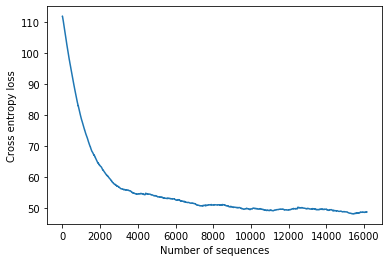

In [44]:
model.plot_losses()